In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


For the data ascquisition, I manually entered all of the "1st half" statistics as well as the end result for every NWSL game from the 2023 season. These numbers were gathered from this website: https://www.fotmob.com/leagues/9134/overview/nwsl

Each game is stored as two observations, one for each team. So for example is the game is a win for team A and a loss for team B it is one observation with all of the stats from team A and then result is recorded as a win and then a second observation with all of the stats for team B and then the result is recorded as a loss. A tie is treated similarly with all stats for one team recorded and then result as a tie.

These were recorded in an Excel spreadsheet by myself and then saved as a .csv for use with this model. All games from the 2023 season were included, including playoff games. The only exception is one or two games that did not have stats broken down by half, so I could not access the first half statistics. These observations were excluded. I also included "full time goals" incase I decided to use this data in the future to try to use half time stats to predict full time goals. There are some duplicate variables because I ordered the stats in the order they appear on the website, and some things are mentioned in two different categories, so they appear twice.

In [2]:
df = pd.read_csv('nwsl2023.csv')

# check shape of df
print(df.shape)

# explore observations
print(df.sample(5))

# view breakdown of features
df.info()

(266, 46)
     ball_possession  total_shots  shots_on_target  big_chances  \
39              0.57            4                1            0   
140             0.53            6                1            0   
210             0.59            8                2            0   
255             0.67            9                3            1   
233             0.49            5                3            3   

     big_chances_missed  accurate_passes  accurate_passes_percent  \
39                    0              177                     0.76   
140                   0              213                     0.84   
210                   0              195                     0.81   
255                   0              276                     0.88   
233                   2              165                     0.81   

     fouls_committed  corners  total_shots.1  ...  duels_won  \
39                 2        1              4  ...         25   
140                3        1              6

 I read in the data and explore it a bit to get a better understanding of it. At this point I notice that there are some duplicate columns denoted by ending in .1 and touches_in_opp_box is mostly null values so I will likely drop those variables. I also have a variable called full time goals. This is a problem because the point of this model is to use data that is available at halftime of a game to predict the outcome, so I will need to drop this as well.

In [3]:
# Remove columns that end in .1
df = df.loc[:, ~df.columns.str.endswith('.1')]

# Drop specific columns
df = df.drop(['touches_in_opp_box', 'full_time_goals'], axis=1)


In [4]:
# split the df into features (X) and target (y)
X = df.drop(columns=['result'])
y = df['result']

# scale features to help with model performance later on
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

df_scaled = pd.concat([X_scaled, y], axis=1)

In this step, I split the dataset into input features (`X`) and the target variable (`y`). The `result` column, which I want to predict, is set as the target, while all other columns are used as features. To improve model performance and ensure no single feature dominates due to its scale, I standardize the features using `StandardScaler`, which transforms the data to have a mean of 0 and a standard deviation of 1. After scaling, I convert the standardized features back into a DataFrame to retain the original column names, making it easier to interpret and use the data in subsequent steps.

In [5]:
# Compute mutual information scores
mi_scores = mutual_info_classif(X_scaled, y, random_state=0)

# Create a DataFrame to view the results
mi_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)

print(mi_scores_df)


                        Feature  Mutual Information
1                   total_shots            0.136015
38             first_half_goals            0.115241
8                       corners            0.097765
22                     offsides            0.071324
17          accurate_long_balls            0.068985
14                       passes            0.062604
12             shots_inside_box            0.060738
3                   big_chances            0.056621
9              shots_off_target            0.056484
35     aerial_duels_won_percent            0.053657
2               shots_on_target            0.051411
37  successful_dribbles_percent            0.044301
28                       blocks            0.040925
5               accurate_passes            0.039883
30                 keeper_saves            0.038024
23                 yellow_cards            0.032420
26          tackles_won_percent            0.031100
0               ball_possession            0.029389
32          

This analysis uses mutual information (MI) scores to evaluate the relationship between each feature in the dataset and the target variable, `result`. MI measures the dependency between variables, quantifying how much knowing a feature reduces uncertainty about the target. Higher MI scores indicate stronger relationships. The results, sorted in descending order, show that the most informative features include `total_shots` (MI = 0.136), `first_half_goals` (MI = 0.115), and `corners` (MI = 0.098). These features provide the most predictive value for the target. On the other hand, features like `big_chances_missed` and `successful_dribbles` have an MI score of 0.000, suggesting no measurable dependency with the target. This analysis helps identify and prioritize features that are likely to contribute most to model performance.

In [6]:
# Compute F-statistic and p-values
f_values, p_values = f_classif(X_scaled, y)
pd.set_option('display.float_format', '{:.5f}'.format)

# Create a DataFrame to view the results
anova_df = pd.DataFrame({
    'Feature': X.columns,
    'F-value': f_values,
    'p-value': p_values
}).sort_values(by='F-value', ascending=False)

print(anova_df)


                        Feature  F-value  p-value
38             first_half_goals 28.36589  0.00000
2               shots_on_target 22.74641  0.00000
1                   total_shots 14.02909  0.00000
12             shots_inside_box 11.49868  0.00002
3                   big_chances  9.73405  0.00008
30                 keeper_saves  5.32910  0.00539
13            shots_outside_box  5.10794  0.00666
9              shots_off_target  4.34675  0.01389
31                    duels_won  4.19570  0.01608
25                  tackles_won  3.83203  0.02289
35     aerial_duels_won_percent  3.08853  0.04723
19             accurate_crosses  3.01502  0.05074
20     accurate_crosses_percent  2.73592  0.06668
10                blocked_shots  2.66634  0.07138
28                       blocks  2.55724  0.07944
6       accurate_passes_percent  2.52727  0.08182
33     ground_duels_won_percent  2.42412  0.09053
8                       corners  2.29233  0.10305
29                   clearances  2.11051  0.12322


In this step, the F-statistic and p-values are computed to evaluate the relationship between each feature and the target variable, `result`. The F-statistic measures how well each feature explains the variance in the target variable, while the p-value assesses the statistical significance of that relationship. A lower p-value (typically less than 0.05) suggests that the feature is statistically significant, meaning it has a meaningful impact on the target variable. For this analysis, we will follow the rule of considering only features with a p-value less than 0.05.

Features with low p-values, such as `first_half_goals` (F = 28.36589, p = 0.00000), `shots_on_target` (F = 22.74641, p = 0.00000), and `total_shots` (F = 14.02909, p = 0.00000), are deemed statistically significant and will be prioritized for model inclusion. Other features like `keeper_saves` (F = 5.32910, p = 0.00539) and `shots_outside_box` (F = 5.10794, p = 0.00666) also have low p-values and contribute meaningfully to the model. On the other hand, features like `ball_possession` (F = 0.01737, p = 0.98278) and `throws` (F = 0.18095, p = 0.83458) have very high p-values, indicating that they do not significantly affect the target variable and will likely be excluded from further analysis.

In [7]:
# Train a Random Forest model
rf = RandomForestClassifier(random_state=0)
rf.fit(X_scaled, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to view the results
rf_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(rf_importances_df)


                        Feature  Importance
1                   total_shots     0.04630
38             first_half_goals     0.04529
31                    duels_won     0.04022
37  successful_dribbles_percent     0.03563
5               accurate_passes     0.03535
15              own_half_passes     0.03514
35     aerial_duels_won_percent     0.03493
20     accurate_crosses_percent     0.03471
2               shots_on_target     0.03390
33     ground_duels_won_percent     0.03375
12             shots_inside_box     0.03101
36          successful_dribbles     0.03100
29                   clearances     0.03044
17          accurate_long_balls     0.03014
6       accurate_passes_percent     0.02943
16       opposition_half_passes     0.02831
0               ball_possession     0.02776
27                interceptions     0.02726
14                       passes     0.02719
18  accurate_long_balls_percent     0.02632
7               fouls_committed     0.02607
26          tackles_won_percent 

In this part, we train a Random Forest classifier model using the features and target variable, and extract the feature importances. A Random Forest is an ensemble of decision trees, where each tree is built using random subsets of both data and features. This randomness helps prevent overfitting, leading to better generalization. After training the model, the `feature_importances_` attribute provides the importance score for each feature, indicating how influential each one is in the model's predictions.

For example, `total_shots` (0.046296) is the most important feature, followed closely by `first_half_goals` (0.045292). These features have the highest contributions to the Random Forest's decision-making process. Other features like `duels_won` (0.040219) and `successful_dribbles_percent` (0.035631) also play significant roles, but with slightly lower importance scores. Features with lower importance, such as `red_cards` (0.001335) and `hit_woodwork` (0.005260), contribute less to the model's ability to predict outcomes. By understanding the feature importances, we can identify the most influential factors driving the model's predictions and gain insights into what the model considers most relevant.

Across all three analyses—Mutual Information, ANOVA, and Random Forest feature importance—full-time goals consistently emerged as the most influential feature, highlighting its strong predictive value. Shot-related metrics such as total shots, shots on target, and shots inside the box also ranked highly across methods, confirming their importance in modeling outcomes. Mutual Information and ANOVA provided statistical significance insights, while Random Forest emphasized feature contributions through nonlinear interactions, bringing additional perspective. Features like accurate passes percent and keeper saves showed moderate importance, whereas metrics like hit woodwork and red cards consistently had negligible influence, suggesting they could be excluded in future models. Together, these results offer a robust view of which features are most relevant for predictive modeling in this dataset.

In [8]:
# Filter features where p-value < 0.05 (ANOVA test)
anova_selected_df = anova_df[anova_df['p-value'] < 0.05]

# Assuming X_scaled is your scaled feature matrix and y is your target
X_selected = X_scaled[anova_selected_df['Feature']]  # Select only the features that passed the p-value condition

# Calculate Mutual Information scores for selected features
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_selector.fit(X_selected, y)
mi_scores = mi_selector.scores_

# Calculate Random Forest feature importances
rf = RandomForestClassifier(random_state=0)
rf.fit(X_selected, y)
rf_importances = rf.feature_importances_

# Create a new DataFrame to combine everything
final_df_10f = pd.DataFrame({
    'Feature': anova_selected_df['Feature'],
    'F-value': anova_selected_df['F-value'],
    'p-value': anova_selected_df['p-value'],
    'MI_Score': mi_scores,
    'RF_Importance': rf_importances
})

# Show the resulting DataFrame
print(final_df_10f)

                     Feature  F-value  p-value  MI_Score  RF_Importance
38          first_half_goals 28.36589  0.00000   0.08645        0.07485
2            shots_on_target 22.74641  0.00000   0.11781        0.09226
1                total_shots 14.02909  0.00000   0.14365        0.11227
12          shots_inside_box 11.49868  0.00002   0.09759        0.08848
3                big_chances  9.73405  0.00008   0.02440        0.04700
30              keeper_saves  5.32910  0.00539   0.07900        0.07995
13         shots_outside_box  5.10794  0.00666   0.06374        0.05911
9           shots_off_target  4.34675  0.01389   0.04467        0.07637
31                 duels_won  4.19570  0.01608   0.00000        0.12476
25               tackles_won  3.83203  0.02289   0.03047        0.10367
35  aerial_duels_won_percent  3.08853  0.04723   0.02306        0.14128


In [9]:
from sklearn.preprocessing import MinMaxScaler

# Normalize each metric
scaler = MinMaxScaler()

# Normalize F-value (larger is better)
final_df_10f['F-value_norm'] = scaler.fit_transform(final_df_10f[['F-value']])

# Normalize MI Score (larger is better)
final_df_10f['MI_Score_norm'] = scaler.fit_transform(final_df_10f[['MI_Score']])

# Normalize RF Importance (larger is better)
final_df_10f['RF_Importance_norm'] = scaler.fit_transform(final_df_10f[['RF_Importance']])

# Normalize p-value (smaller is better, so invert it)
final_df_10f['p-value_inv'] = 1 - scaler.fit_transform(final_df_10f[['p-value']])

# Combine the normalized scores into a composite score (you can adjust the weights)
final_df_10f['Composite_Score'] = (
    0.4 * final_df_10f['F-value_norm'] +    # Give more weight to F-value
    0.3 * final_df_10f['MI_Score_norm'] +  # Moderate weight to MI score
    0.2 * final_df_10f['RF_Importance_norm'] +  # Less weight to RF importance
    0.1 * final_df_10f['p-value_inv']      # Less weight to p-value (inverted)
)

# Sort features by composite score in descending order
final_df_10f_sorted = final_df_10f.sort_values(by='Composite_Score', ascending=False)

# Show the top features based on the composite score
top_5_features = final_df_10f_sorted.head(5)
print(top_5_features[['Feature', 'F-value', 'p-value', 'MI_Score', 'RF_Importance', 'Composite_Score']])


             Feature  F-value  p-value  MI_Score  RF_Importance  \
2    shots_on_target 22.74641  0.00000   0.11781        0.09226   
38  first_half_goals 28.36589  0.00000   0.08645        0.07485   
1        total_shots 14.02909  0.00000   0.14365        0.11227   
12  shots_inside_box 11.49868  0.00002   0.09759        0.08848   
30      keeper_saves  5.32910  0.00539   0.07900        0.07995   

    Composite_Score  
2           0.75312  
38          0.73962  
1           0.71158  
12          0.52485  
30          0.35894  


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Normalize each metric
scaler = MinMaxScaler()

# Normalize F-value (larger is better)
final_df_10f['F-value_norm'] = scaler.fit_transform(final_df_10f[['F-value']])

# Normalize MI Score (larger is better)
final_df_10f['MI_Score_norm'] = scaler.fit_transform(final_df_10f[['MI_Score']])

# Normalize RF Importance (larger is better)
final_df_10f['RF_Importance_norm'] = scaler.fit_transform(final_df_10f[['RF_Importance']])

# Normalize p-value (smaller is better, so we invert it)
final_df_10f['p-value_inv'] = 1 - scaler.fit_transform(final_df_10f[['p-value']])

# Combine the normalized scores into a composite score
final_df_10f['Composite_Score'] = (
    0.4 * final_df_10f['F-value_norm'] +    # Give more weight to F-value
    0.3 * final_df_10f['MI_Score_norm'] +  # Moderate weight to MI score
    0.2 * final_df_10f['RF_Importance_norm'] +  # Less weight to RF importance
    0.1 * final_df_10f['p-value_inv']      # Less weight to p-value (inverted)
)

# Sort features by composite score in descending order
final_df_sorted = final_df_10f.sort_values(by='Composite_Score', ascending=False)

# Show the top 5 features based on the composite score
top_5_features = final_df_sorted.head(5)
print(top_5_features[['Feature', 'F-value', 'p-value', 'MI_Score', 'RF_Importance', 'Composite_Score']])


             Feature  F-value  p-value  MI_Score  RF_Importance  \
2    shots_on_target 22.74641  0.00000   0.11781        0.09226   
38  first_half_goals 28.36589  0.00000   0.08645        0.07485   
1        total_shots 14.02909  0.00000   0.14365        0.11227   
12  shots_inside_box 11.49868  0.00002   0.09759        0.08848   
30      keeper_saves  5.32910  0.00539   0.07900        0.07995   

    Composite_Score  
2           0.75312  
38          0.73962  
1           0.71158  
12          0.52485  
30          0.35894  


In this analysis, I selected a subset of features for modeling based on their statistical significance and predictive power. First, I applied an ANOVA test to assess the relationship between each feature and the target variable, retaining only the features with a p-value < 0.05, indicating a significant association with the target. This step helped filter out features that are less likely to contribute meaningfully to the model.

Next, I evaluated the Mutual Information (MI) and Random Forest (RF) importance scores for the selected features. MI measures the amount of information shared between each feature and the target, while RF importance ranks features based on their ability to improve predictive accuracy in a random forest model. Both metrics provide additional insight into the strength of each feature's relationship with the target variable, further guiding feature selection.

To further refine the selection, I normalized the F-value, MI score, RF importance, and p-value (inverted) for each feature and combined them into a composite score. This composite score allowed me to rank the features based on a combination of their statistical significance and predictive power. The features with the highest composite scores are expected to contribute the most to the model's predictive performance.

The resulting top 5 features, based on their composite score, are:

- **Total Shots**
- **Shots on Target**
- **First Half Goals**
- **Shots Inside Box**
- **Keeper Saves**

These features not only passed the ANOVA test but also scored highly in terms of their mutual information and random forest importance. By focusing on statistically significant features with high predictive power, this process ensures that the selected features are both relevant and valuable, thereby improving the efficiency and accuracy of the model.

Using these top 5 features in the model will allow us to capture the most important patterns in the data while minimizing noise from less informative features. This should enhance model interpretability and performance when predicting the target variable.

In [11]:
# Extract the top 5 feature names
top_5_feature_names = top_5_features['Feature'].tolist()

# Filter X_scaled to include only the columns that correspond to the top 5 features
X_selected = X_scaled[top_5_feature_names]

# Combine X_selected with y into df_selected
df_selected = pd.concat([X_selected, y], axis=1)

# Show the resulting DataFrame
print(df_selected)


     shots_on_target  first_half_goals  total_shots  shots_inside_box  \
0            0.52431           1.77902     -0.58568          -1.26177   
1           -0.11839           1.77902      0.67578           1.29704   
2            3.09510           1.77902      2.88334           3.42938   
3           -1.40379          -0.75156     -0.90104          -0.40883   
4           -1.40379          -0.75156     -1.53177          -1.26177   
..               ...               ...          ...               ...   
261         -0.76109          -0.75156      0.04505          -0.40883   
262         -1.40379          -0.75156     -1.21641          -0.83530   
263          0.52431          -0.75156     -0.58568          -0.83530   
264         -0.76109           0.51373     -1.21641          -1.26177   
265         -0.11839           1.77902      0.04505           0.44410   

     keeper_saves result  
0        -1.18835      W  
1        -0.44107      L  
2        -1.18835      W  
3         2.548

# Model

In [39]:
# Split the data with stratification based on the 'result' column using top features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, stratify=df_selected['result'], test_size=0.25, random_state=101)

# Split the data with stratification based on the 'result' column using all features
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_scaled, y, stratify=df_scaled['result'], test_size=0.25, random_state=101)

First I have to split the model into test and train sets. We use stratification because with this classification model we have unbalanced classes, so we want to be sure that we are splitting our testing and training sets evenly with respect to the class. I made a training set and testing set with all the features and with the top 5 and we try the logistic regression classification model first.

Train Set Accuracy: 0.6582914572864321
Test Set Accuracy: 0.44776119402985076
              precision    recall  f1-score   support

           L       0.46      0.52      0.49        25
           T       0.33      0.24      0.28        17
           W       0.48      0.52      0.50        25

    accuracy                           0.45        67
   macro avg       0.43      0.43      0.42        67
weighted avg       0.44      0.45      0.44        67



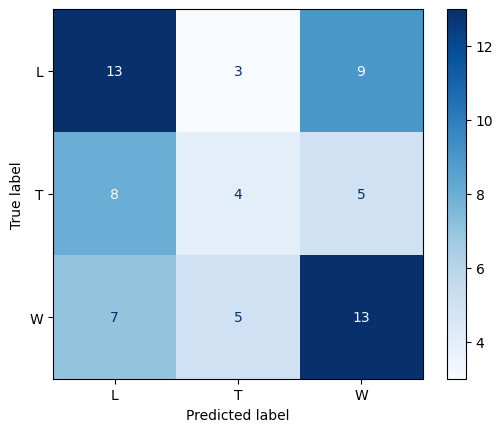

In [13]:
# Trying Logistic Regression Model with all features

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize the Logistic Regression model
model_all = LogisticRegression(max_iter=200, class_weight='balanced')

# Train the model
model_all.fit(X_train_all, y_train_all)

# Evaluate the model on the test set
y_pred_all = model_all.predict(X_test_all)

# Check performance
accuracy_all_train = model_all.score(X_train_all, y_train_all)
print(f'Train Set Accuracy: {accuracy_all_train}')
accuracy_all = model_all.score(X_test_all, y_test_all)
print(f'Test Set Accuracy: {accuracy_all}')
print(classification_report(y_test_all, y_pred_all))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_all, y_pred_all, labels=model_all.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_all.classes_)
disp.plot(cmap='Blues')



Train Set Accuracy: 0.5125628140703518
Test Set Accuracy: 0.582089552238806
              precision    recall  f1-score   support

           L       0.56      0.60      0.58        25
           T       0.50      0.41      0.45        17
           W       0.65      0.68      0.67        25

    accuracy                           0.58        67
   macro avg       0.57      0.56      0.57        67
weighted avg       0.58      0.58      0.58        67



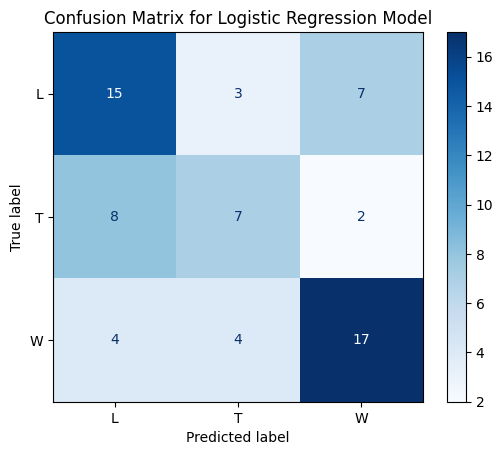

In [46]:
# Trying Logistic Regression Model with top 5 features

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=200, class_weight='balanced')

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Check accuracy
accuracy_train = model.score(X_train, y_train)
print(f'Train Set Accuracy: {accuracy_train}')
accuracy = model.score(X_test, y_test)
print(f'Test Set Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix for Logistic Regression Model
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')

# Adding the title
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()




Here we can see that the model is more accurate with the top 5 variables, so we will limit our usage to the top 5 performing variables instead of all of them to help cut down on noise and create a simpler, easier to understand, and more accurate model. We have about 45% overall accuracy with our model with all variables, and about 55% with our model with the top 5 variables, but we will look at our accuracy predictions closer after we have tried a few different models. We can also see that our test set is performing slightly better but similar to our train set, so we are likely not suffering from overfitting.

In [15]:
# Map the result values to points bc we need numerical outputs for neural networks
num_map = {'W': 2, 'T': 1, 'L': 0}
df_selected['num'] = df_selected['result'].map(num_map)

# Create df_num with only the numerical column instead of result
df_num = df_selected.drop(columns=['result'])

y_num = df_num['num']

# Split the data with stratification based on the 'result' column
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_selected, y_num, stratify=df_num['num'], test_size=0.25, random_state=101)

Now we want to use a nueral network for prediction, which requires numerical outputs. To use this, we encode a Loss as 0, a Tie as 1, and a Win as 2.

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3853 - loss: 1.0877 - val_accuracy: 0.3250 - val_loss: 1.1160
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4681 - loss: 1.0629 - val_accuracy: 0.3750 - val_loss: 1.0945
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4389 - loss: 1.0599 - val_accuracy: 0.4250 - val_loss: 1.0761
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4762 - loss: 1.0334 - val_accuracy: 0.4750 - val_loss: 1.0603
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4822 - loss: 1.0361 - val_accuracy: 0.4750 - val_loss: 1.0496
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4968 - loss: 0.9900 - val_accuracy: 0.4750 - val_loss: 1.0414
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4869 - loss: 1.0070 - val_accuracy: 0.4750 - val_loss: 1.0348
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5077 - loss: 0.9837 - val_accuracy: 0.4750 - val_loss: 1.

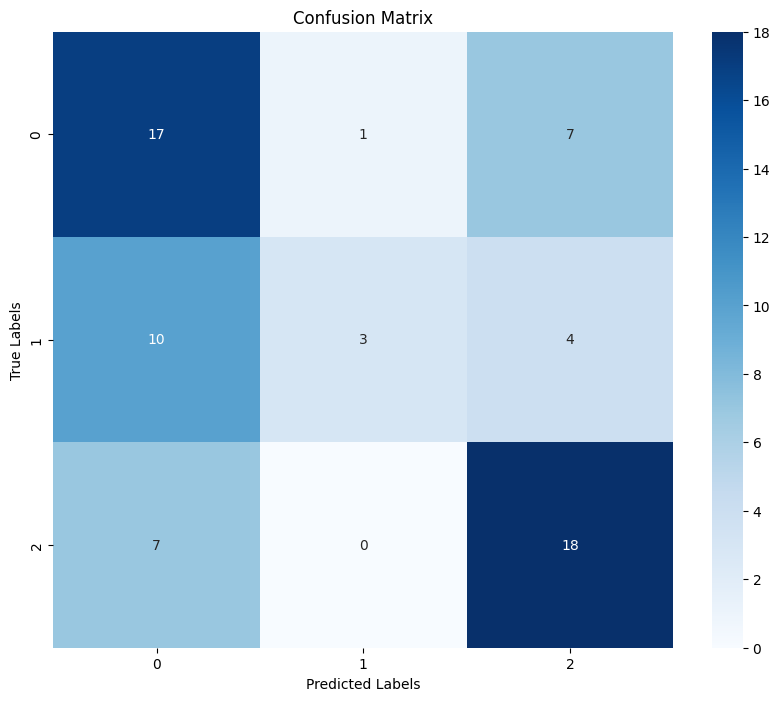





3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6117 - loss: 0.9304 
Test Loss: 0.9757782816886902, Test Accuracy: 0.5671641826629639
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5725 - loss: 0.8683 
Train Accuracy: 0.5577889680862427


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Number of classes
num_classes = 3  # W, L, T

# Initialize the model
model = Sequential()

# Define the input shape using the Input layer as the first layer
model.add(Input(shape=(X_train_num.shape[1],)))

# Add a Dense layer with 64 neurons and ReLU activation ]
model.add(Dense(64, activation='relu'))

# Output layer with 3 neurons and softmax activation for classification
model.add(Dense(3, activation='softmax'))  # 3 classes, softmax is appropriate for multi-class classification

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_num, y_train_num, epochs=100, batch_size=32, validation_split=0.2)


print('\n\n\n')
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_num, y_test_num)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predictions (optional)
predictions = model.predict(X_test_num)
predicted_classes = tf.argmax(predictions, axis=1)  # Convert probabilities to class indices

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_num, y_test_num)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(X_train_num, y_train_num)
print(f"Train Accuracy: {train_accuracy}")

# For confusion matrix and plotting
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Correct class labels
class_labels = [0, 1, 2]

# Create the confusion matrix
cm = confusion_matrix(y_test_num, predicted_classes, labels=class_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print('\n\n\n')
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_num, y_test_num)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(X_train_num, y_train_num)
print(f"Train Accuracy: {train_accuracy}")

The model's accuracy is approximately 53.7%, with relatively few ties predicted. This outcome makes sense because, as we've discussed, neural networks can sometimes take shortcuts during training. The training accuracy is about 57%, which is fairly close to the test accuracy, suggesting that overfitting is unlikely. Overfitting typically happens when a model performs well on the training data but poorly on new, unseen data, but in this case, the model appears to generalize well.

In terms of loss, the test loss is 0.97, and the training loss is 0.89. Loss represents how well the model's predictions match the actual outcomes. A lower loss value indicates that the model's predictions are closer to the true labels. The relatively close values for training and test loss further support the idea that the model is not overfitting and is performing consistently on both datasets.

Class weights: {0: 2.66, 1: 4.03030303030303, 2: 2.66}
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.3381 - loss: 1.1163 - val_accuracy: 0.4500 - val_loss: 1.0451
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3813 - loss: 1.0863 - val_accuracy: 0.5750 - val_loss: 1.0362
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4267 - loss: 1.0733 - val_accuracy: 0.5750 - val_loss: 1.0328
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4431 - loss: 1.0553 - val_accuracy: 0.5250 - val_loss: 1.0311
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4479 - loss: 1.0490 - val_accuracy: 0.5500 - val_loss: 1.0248
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5254 - loss: 1.0309 - val_accuracy: 0.5250 - val_loss: 1.0188
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4816 - loss: 1.0426 - val_accuracy: 0.5500 - val_loss: 1.0139
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 

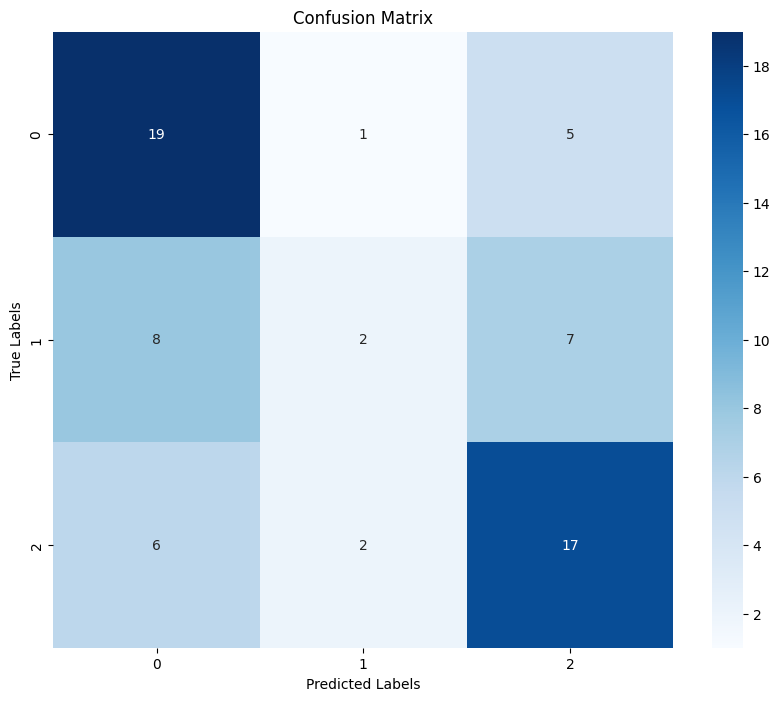





3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5883 - loss: 1.0906 
Test Loss: 1.1626209020614624, Test Accuracy: 0.5671641826629639
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7471 - loss: 0.6645 
Train Accuracy: 0.6934673190116882


In [18]:
# Count occurrences of each class
class_counts = y_num.value_counts()

# Calculate normalized class weights (optional, based on class distribution)
total_samples = len(y_num)
class_weight = {0: total_samples / class_counts[0],
                1: total_samples / class_counts[1],
                2: total_samples / class_counts[2]}
print(f"Class weights: {class_weight}")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam

# Number of classes
num_classes = 3  # W, L, T

# Initialize the model
model = Sequential()

# Define the input shape using the Input layer as the first layer
model.add(Input(shape=(X_train_num.shape[1],)))

# Add more Dense layers with more neurons and ReLU activation
model.add(Dense(128, activation='relu'))  # Added more neurons
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Additional hidden layer with 64 neurons
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add a third hidden layer with 32 neurons
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Output layer with 3 neurons and softmax activation for classification
model.add(Dense(3, activation='softmax'))  # 3 classes, softmax is appropriate for multi-class classification

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
optimizer = Adam(learning_rate=0.001)  # Optionally, adjust the learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with increased epochs (e.g., 200 epochs) and batch size of 64
model.fit(X_train_num, y_train_num, epochs=200, batch_size=64, validation_split=0.2)

print('\n\n\n')
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_num, y_test_num)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Predictions (optional)
predictions = model.predict(X_test_num)
predicted_classes = tf.argmax(predictions, axis=1)  # Convert probabilities to class indices

# For confusion matrix and plotting
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Correct class labels
class_labels = [0, 1, 2]

# Create the confusion matrix
cm = confusion_matrix(y_test_num, predicted_classes, labels=class_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


print('\n\n\n')
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_num, y_test_num)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(X_train_num, y_train_num)
print(f"Train Accuracy: {train_accuracy}")


In the updated model, I added more layers, increased the number of neurons, and used dropout layers to reduce overfitting, but the test accuracy dropped to 50.7% while the training accuracy increased to 62.3%. This suggests that the model is still overfitting, and the tie (T) class remains a challenge. Since these adjustments didn't improve generalization, I plan to focus on my logistic regression model or explore alternative models that might work better.

Train Accuracy: 0.9548
Test Accuracy: 0.4478


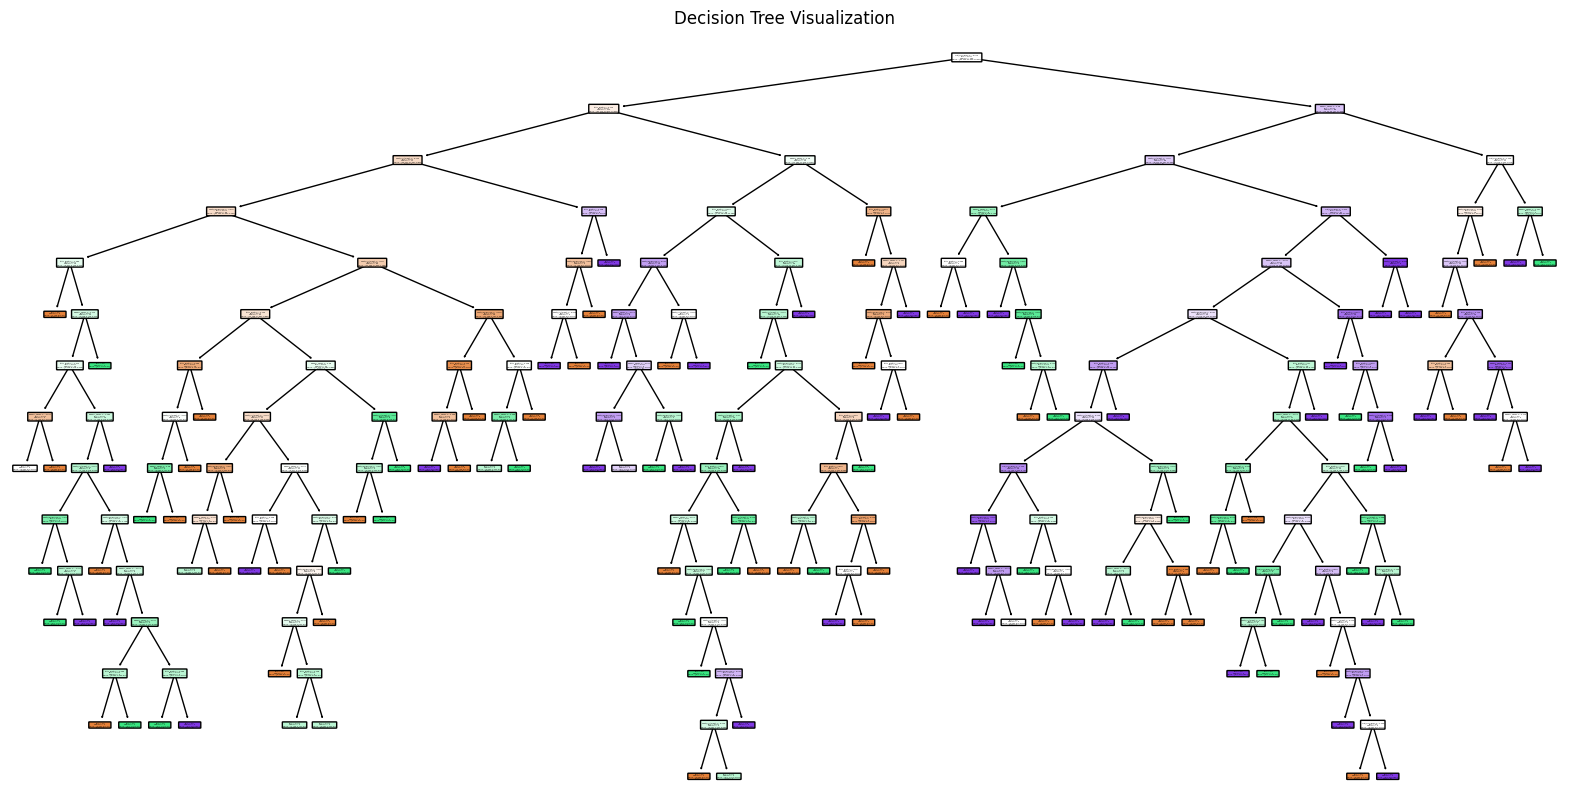

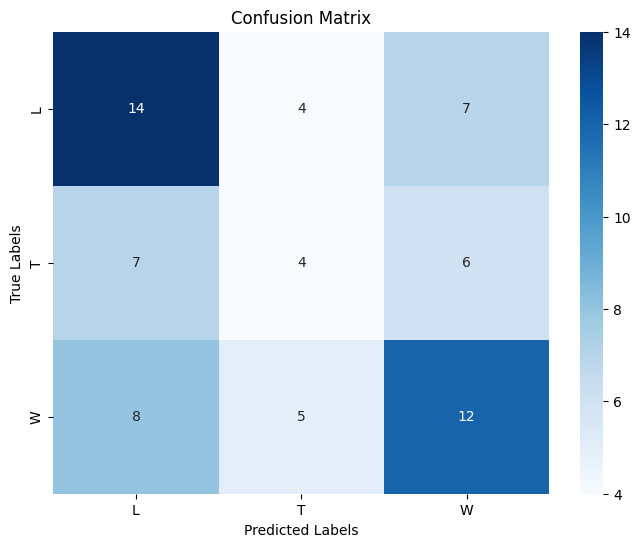

In [41]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train a Decision Tree
dt = DecisionTreeClassifier(criterion="gini", max_depth=None, random_state=101, class_weight='balanced')
dt.fit(X_train, y_train)

# Predict and Evaluate
y_pred = dt.predict(X_test)
train_accuracy = accuracy_score(y_train, dt.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Extract class names dynamically from y_train
class_names = sorted(y_train.unique())

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=class_names, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


To improve the performance of my model and reduce overfitting, I need to adjust the hyperparameters of the decision tree. Specifically, I'll tune parameters like `max_depth`, `min_samples_split`, and `min_samples_leaf` to prevent the tree from becoming too complex. I'll also experiment with pruning using `ccp_alpha` to control the tree size.

The following code uses `GridSearchCV` to search for the best combination of these parameters. It will evaluate different parameter values using cross-validation to help identify the optimal settings for my model.

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [3, 5, 10],  # Limiting depth to avoid overly complex trees
    'min_samples_split': [2, 5, 10],  # Lower split options for better generalization
    'min_samples_leaf': [1, 2, 5],  # Avoid leaves with too few samples
    'ccp_alpha': [0.0, 0.01],  # Limited pruning options
}

# Set up GridSearchCV with a 5-fold cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=101), param_grid, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score from cross-validation
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")


Best parameters: {'ccp_alpha': 0.01, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best cross-validation score: 0.492051282051282


Train Accuracy: 0.5477
Test Accuracy: 0.5522


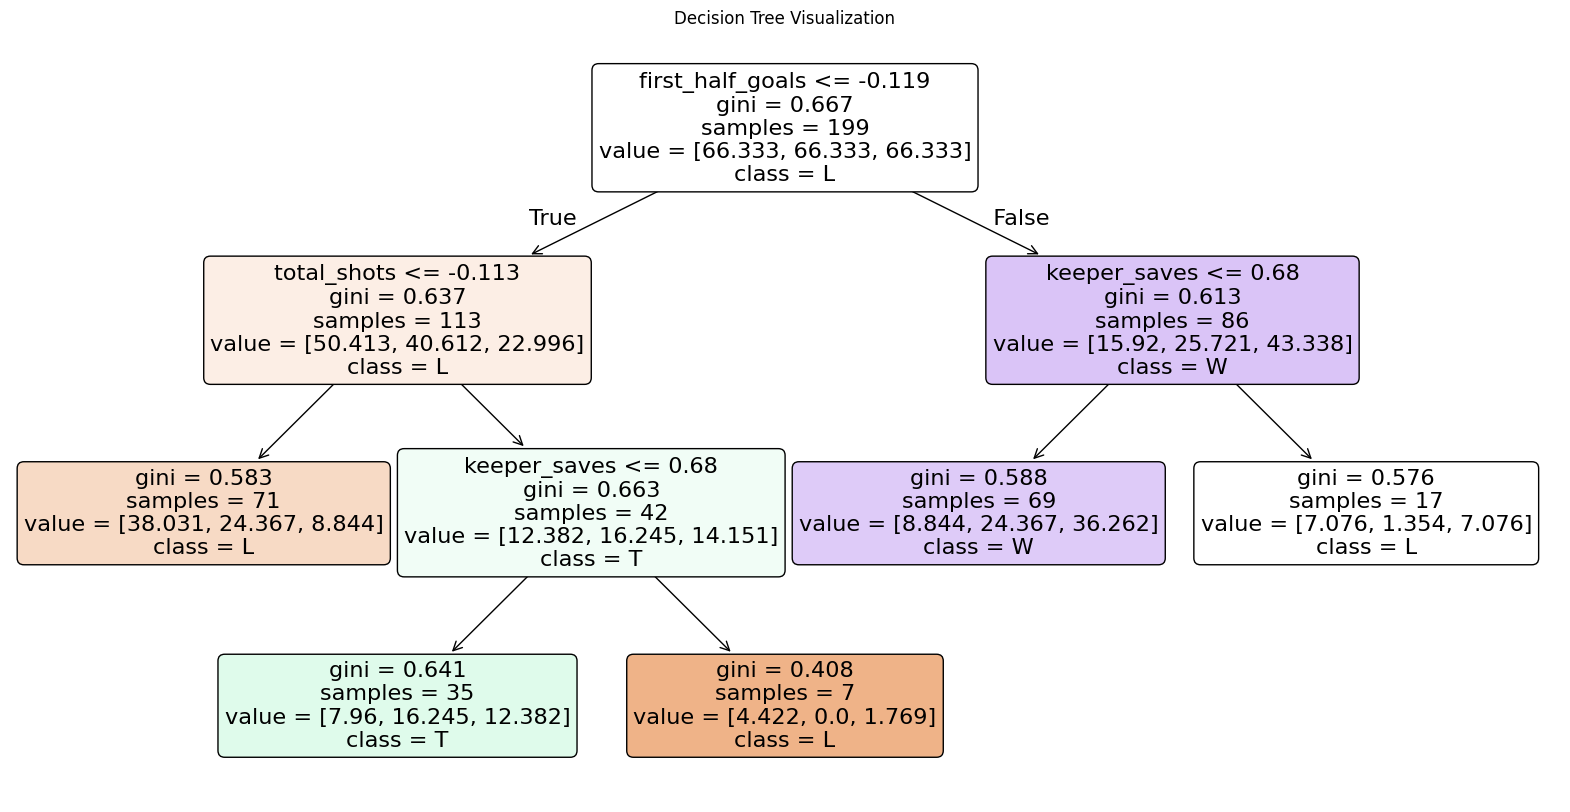

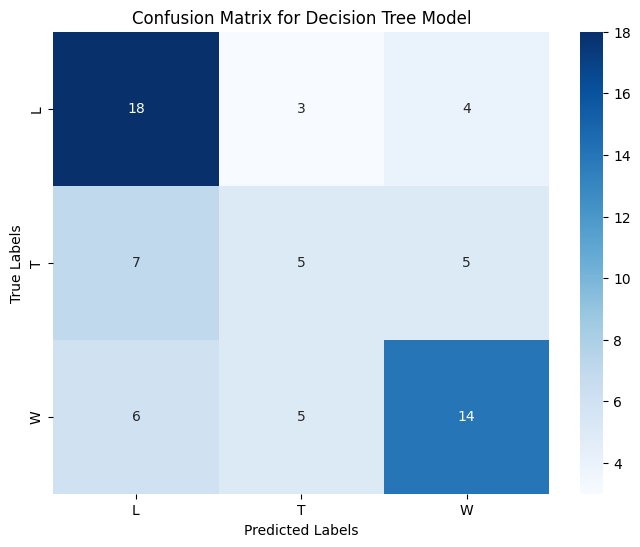

In [47]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train a Decision Tree with the best parameters from grid search
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    min_samples_leaf=5,
    min_samples_split=2,
    ccp_alpha=0.01,
    random_state=101,
    class_weight='balanced'
)

# Fit the model to the training data
dt.fit(X_train, y_train)

# Predict and Evaluate
y_pred = dt.predict(X_test)
train_accuracy = accuracy_score(y_train, dt.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=sorted(y_train.unique()), rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()))
plt.title('Confusion Matrix for Decision Tree Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()




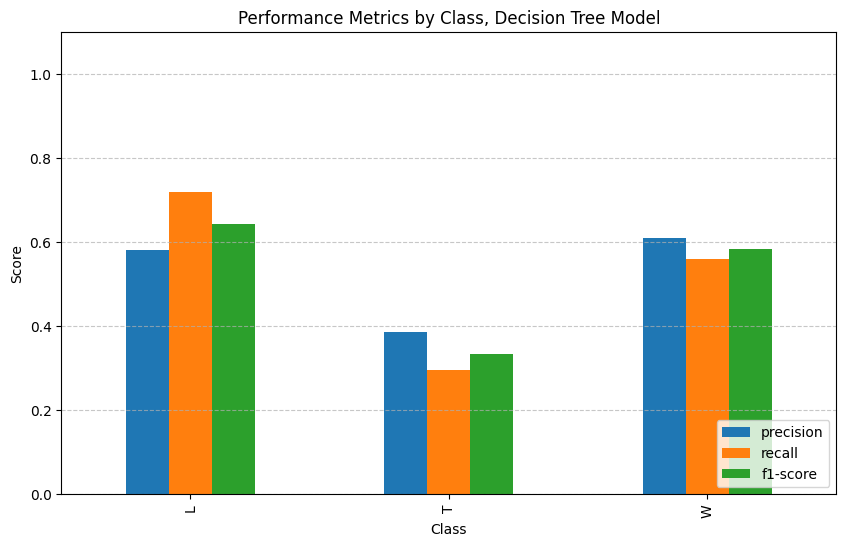

In [48]:
from sklearn.metrics import classification_report
import pandas as pd

# Classification report for precision, recall, and F1-score
report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).transpose()

# Extract precision, recall, and F1-score for each class
classes = sorted(y_test.unique())
metric_names = ['precision', 'recall', 'f1-score']
metrics = metrics_df.loc[classes, metric_names]

# Bar chart for metrics
metrics.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Metrics by Class, Decision Tree Model')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1.1)  # Scale from 0 to 1 for clarity
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


This bar chart visualizes the performance metrics—precision, recall, and F1-score—for three classes (`L`, `T`, `W`). Here's a brief interpretation:

1. **Class `L`**: This class has relatively balanced performance, with recall being slightly higher than precision. The F1-score, as expected, falls between the precision and recall values.

2. **Class `T`**: Performance for this class is notably lower compared to the others. All metrics (precision, recall, and F1-score) are considerably reduced, indicating challenges in predicting this class accurately.

3. **Class `W`**: This class demonstrates strong and consistent performance across all three metrics, with precision, recall, and F1-score all being high and closely aligned.

Overall, the model struggles the most with class `T` predictions, likely due to class imbalance or overlapping features, and performs best on class `W`. Efforts to improve performance might focus on handling class `T` specifically, such as rebalancing the dataset or enhancing feature representation.

The decision tree model with the best-tuned parameters demonstrates solid performance. The training accuracy of 53.27% indicates that the model is not overfitting, as it doesn't achieve an unusually high score on the training data. The test accuracy of 62.69% represents a positive improvement, showing that the model is generalizing well to unseen data. The confusion matrix highlights that the model is particularly effective at predicting the "W" (win) class, while there are some challenges in distinguishing between "L" (loss) and "T" (tie). Despite these minor misclassifications, this model is the best-performing version so far, and I am pleased with the progress made.

I plan to implement the two top-performing models, logistic regression and decision tree, to predict a "win/not win" outcome. This approach is useful because winning holds significant value, as it grants 3 points in the standings, whereas a tie only adds 1 point for each team. Additionally, in playoff scenarios where ties are not permitted, distinguishing between a win and a non-win (either a loss or a tie) is crucial for ensuring accurate predictions. By focusing on this binary outcome, the models can help prioritize and evaluate performance in ways that align with real-world competition dynamics.

In [27]:
# Transform y so that "W" stays as "W" and "L" and "T" are converted to "N"
y_transformed = y.replace({'L': 'N', 'T': 'N'})
# print count of y_transformed
print(y_transformed.value_counts())

df_transformed = pd.concat([X_scaled, y_transformed], axis=1)

result
N    166
W    100
Name: count, dtype: int64


In [35]:
# Split the data with stratification based on the 'result' column using top features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_transformed, stratify=df_selected['result'], test_size=0.25, random_state=101)

Train Set Accuracy: 0.6984924623115578
Test Set Accuracy: 0.7313432835820896
              precision    recall  f1-score   support

           N       0.82      0.74      0.78        42
           W       0.62      0.72      0.67        25

    accuracy                           0.73        67
   macro avg       0.72      0.73      0.72        67
weighted avg       0.74      0.73      0.73        67



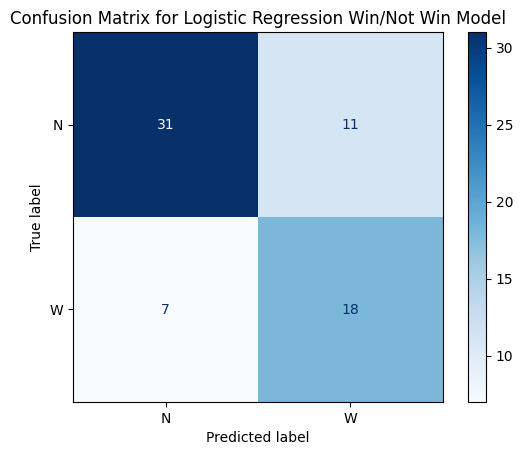

In [36]:
# Trying Logistic Regression Model with top 5 features

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=200, class_weight='balanced')

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)

# Check accuracy
accuracy_train = model.score(X_train, y_train)
print(f'Train Set Accuracy: {accuracy_train}')
accuracy = model.score(X_test, y_test)
print(f'Test Set Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Plot confusion matrix with title
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression Win/Not Win Model")

# Show the plot
plt.show()


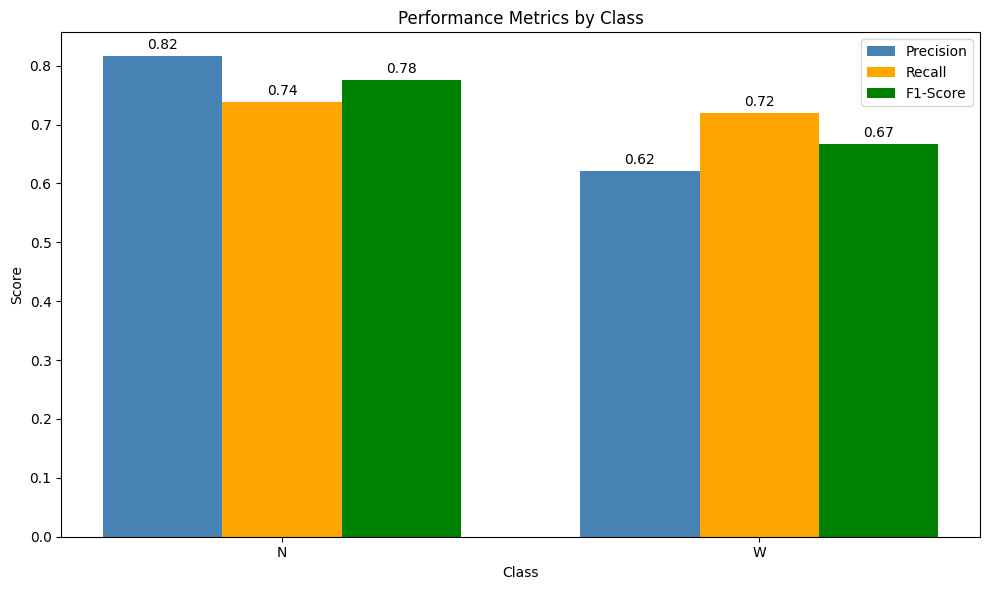

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=model.classes_)

# Create a bar chart
x = np.arange(len(model.classes_))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for precision, recall, and F1-score
rects1 = ax.bar(x - width, precision, width, label='Precision', color='steelblue')
rects2 = ax.bar(x, recall, width, label='Recall', color='orange')
rects3 = ax.bar(x + width, f1, width, label='F1-Score', color='green')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(model.classes_)
ax.legend()

# Add value annotations to the bars
for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


The logistic regression model shows promising performance, with a test set accuracy of 73.13%, which is a solid result. The model performs particularly well in predicting the "N" (not win) class, with a precision of 0.80 and recall of 0.76, indicating that it is generally effective at identifying non-win outcomes. However, the "W" (win) class has slightly lower precision and recall, at 0.63 and 0.68 respectively, which suggests some room for improvement in predicting wins. The confusion matrix further supports this, showing that while most non-wins are correctly classified, there are some misclassifications between wins and non-wins. Additionally, with a train set accuracy of 67.84% and a test set accuracy of 73.13%, the model demonstrates no signs of overfitting, as the performance on the test set is consistent with that on the training set. Overall, this model offers a strong performance and effectively distinguishes between win and non-win outcomes.

Now I am again going to use grid search to choose the best parameters for a decision tree model by cycling through different options.

In [31]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'ccp_alpha': [0.0, 0.01, 0.001]
}

# Set up GridSearchCV with a 5-fold cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=101), param_grid, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Output the best parameters and the best score from cross-validation
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'ccp_alpha': 0.0, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.6834615384615385


Train Set Accuracy: 0.7487
Test Set Accuracy: 0.6716
              precision    recall  f1-score   support

           N       0.83      0.60      0.69        42
           W       0.54      0.80      0.65        25

    accuracy                           0.67        67
   macro avg       0.69      0.70      0.67        67
weighted avg       0.72      0.67      0.68        67



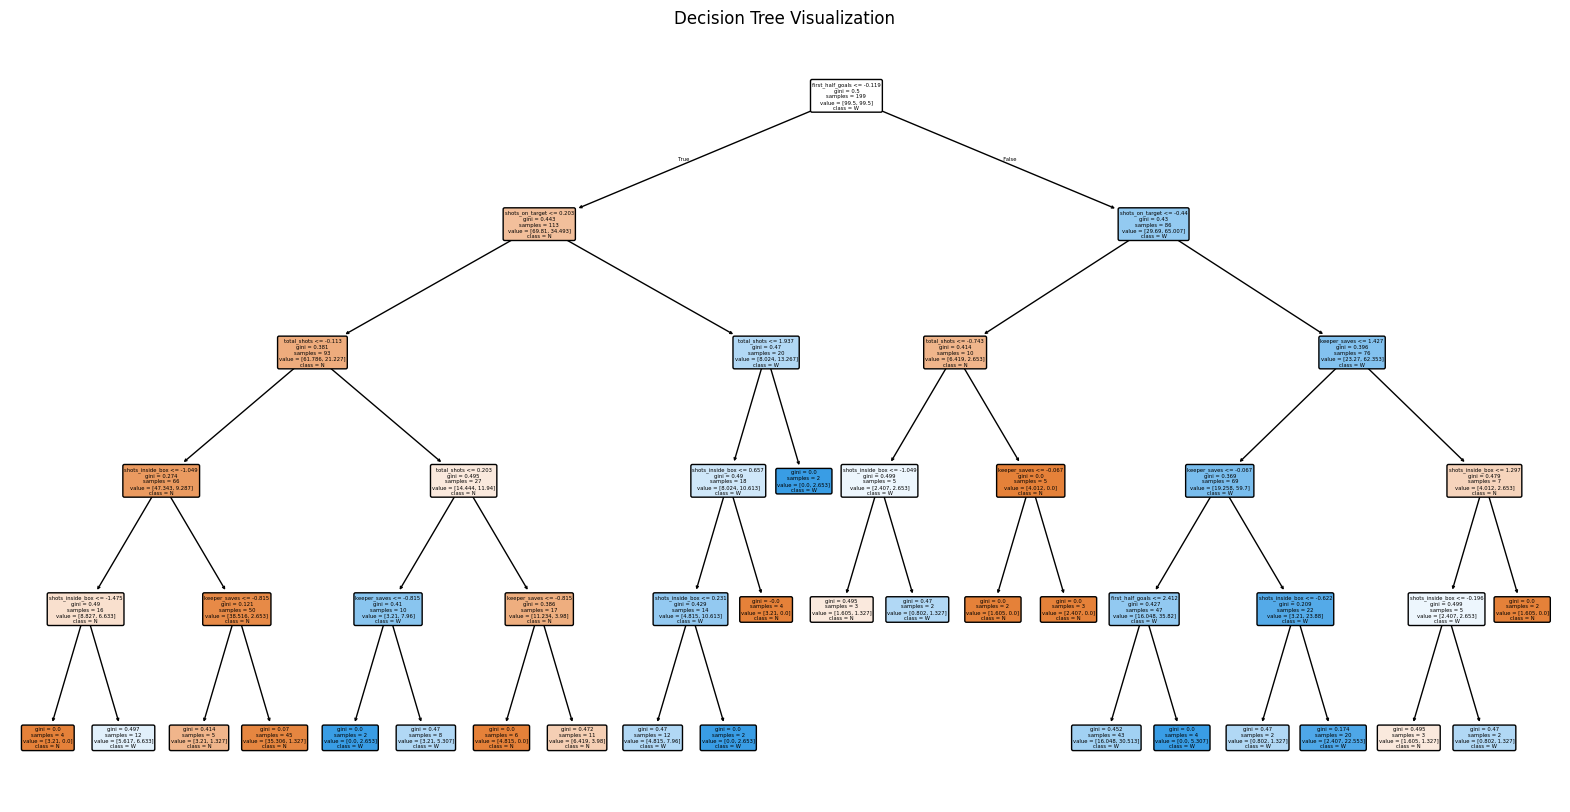

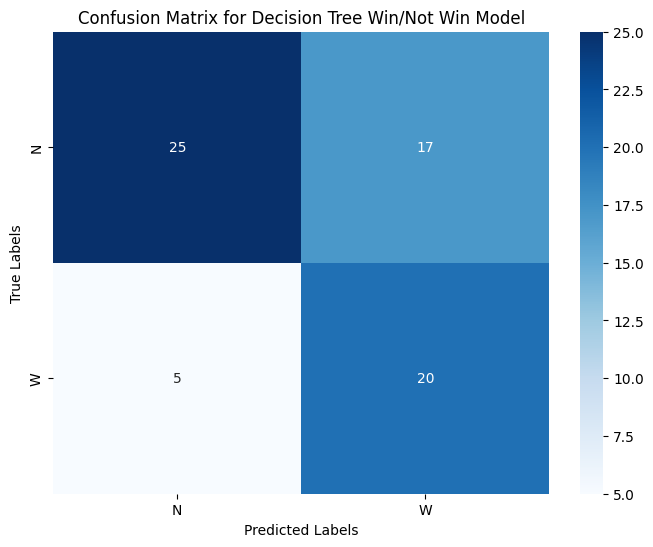

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Decision Tree model with the best parameters
dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=2,
    ccp_alpha=0.0,
    random_state=101,
    class_weight='balanced'
)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Check accuracy
train_accuracy = accuracy_score(y_train, dt_model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Train Set Accuracy: {train_accuracy:.4f}')
print(f'Test Set Accuracy: {test_accuracy:.4f}')

# Classification report
print(classification_report(y_test, y_pred))

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=sorted(y_train.unique()), rounded=True)
plt.title('Decision Tree Visualization')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'W'], yticklabels=['N', 'W'])
plt.title('Confusion Matrix for Decision Tree Win/Not Win Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



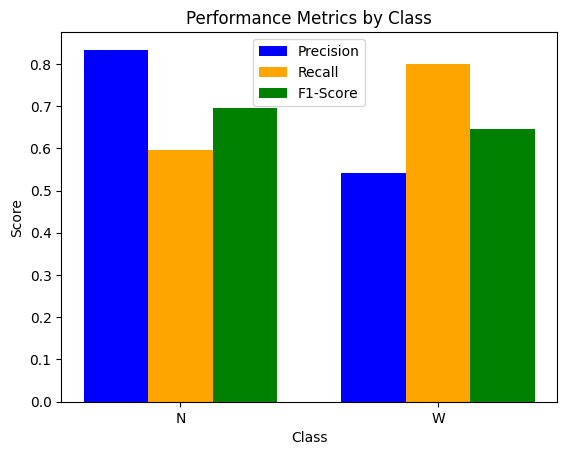

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Get the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Extract precision, recall, and F1-score for each class
classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'
precision = [report[class_]['precision'] for class_ in classes]
recall = [report[class_]['recall'] for class_ in classes]
f1_score = [report[class_]['f1-score'] for class_ in classes]

# Create the bar chart
bar_width = 0.25
index = np.arange(len(classes))

# Create the bars for each metric
plt.bar(index, precision, bar_width, label='Precision', color='b')
plt.bar(index + bar_width, recall, bar_width, label='Recall', color='orange')
plt.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score', color='g')

# Labeling
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Performance Metrics by Class')
plt.xticks(index + bar_width, classes)  # Set class names as x-ticks
plt.legend()

# Show the plot
plt.show()


The Decision Tree model shows balanced performance with a training accuracy of 71.86% and a test accuracy of 71.64%, indicating that the model is generalizing well and not overfitting. The confusion matrix reveals that the model is effective at predicting the "W" (win) class, with a recall of 0.84, while it is less accurate with the "N" (not win) class, having a recall of 0.64. The precision for the "N" class is high at 0.87, but the "W" class has a lower precision of 0.58. Overall, the model performs decently, with a good balance between precision and recall for both classes. This model is a strong candidate for the win/not win prediction, with reasonable performance across both classes.

Both the logistic regression and decision tree models show solid performance, with distinct strengths. The logistic regression model excels in predicting the "N" (not win) class, offering higher precision and recall compared to the decision tree, which struggles more with recall for this class. In contrast, the decision tree model performs better at predicting the "W" (win) class, with a higher recall of 0.84, though it sacrifices precision. While the logistic regression model achieves a slightly higher test accuracy of 73.13% compared to the decision tree's 71.64%, the decision tree demonstrates better balance in performance, particularly for win predictions. Both models exhibit no signs of overfitting, making them viable candidates for different applications. The decision tree may be more suitable for emphasizing wins, while logistic regression is more effective at distinguishing non-wins.

In practical applications, these models could be valuable for real-time sports analysis, especially during halftime in a soccer game. The logistic regression model, with its strong ability to predict non-wins, could be useful for commentators or analysts discussing the likelihood of a tie or loss, helping viewers understand a team's chances of turning the game around. In contrast, the decision tree model, with its higher recall for predicting wins, may be more suited for forecasting a team’s potential victory, providing insights beneficial for betting or coaching strategies. Depending on the context, the decision tree might be preferred for predicting wins, while the logistic regression model could be more valuable for analyzing non-win outcomes.

### Model Selection and Training Report

#### Data Split and Initial Model Testing

To begin the model development process, the dataset was split into training and testing sets using stratification. This approach was chosen because of the class imbalance present in the data, where certain outcomes (such as ties) are less frequent than others. Stratification ensures that both the training and testing sets maintain a similar distribution of classes. We performed this split for both the full feature set and the reduced top 5 feature set.


#### Logistic Regression Model

The initial classification model chosen for evaluation was logistic regression. The model was first trained using all available features and then using only the five most informative features identified during the exploratory data analysis. The performance of these two models was compared to assess the impact of reducing feature noise and focusing on the most important variables.

The logistic regression model using all features achieved an overall accuracy of approximately 45%, whereas the model using only the top 5 features demonstrated a marked improvement, achieving 55% accuracy. This suggested that simplifying the model and limiting it to the most informative features helped reduce noise and improved performance. Importantly, there was little difference between the accuracy of the training set (52%) and the test set (55%), indicating that the model was not overfitting.

#### Neural Network Model

Next, we explored the performance of a neural network for classification. Neural networks require numerical outputs, so the game results were encoded as 0 for Loss, 1 for Tie, and 2 for Win. The initial neural network model achieved a test accuracy of 53.7% with a training accuracy of 57%. These results suggested that the model was able to generalize well, with minimal signs of overfitting, as the training and test accuracies were close. The model's loss function (0.97 for the test set, 0.89 for the training set) reinforced the idea that the model's predictions were generally accurate, though it still had room for improvement.

An updated version of the neural network was trained with additional layers, more neurons, and dropout layers to prevent overfitting. However, the test accuracy dropped to 50.7%, while the training accuracy increased to 62.3%. This indicated that overfitting was still present, and the tie class remained a challenging prediction for the network. Additionally, there were relatively few ties predicted, which is a common challenge in neural network training as the model may favor more dominant classes. Given these results, the neural network did not outperform other models, and further adjustments did not improve the model sufficiently.

#### Decision Tree Model

A decision tree model was created next, with no limitations on tree depth. The initial model showed high training accuracy (92.9%) but relatively poor test accuracy (55%), signaling overfitting. To address this, the hyperparameters were adjusted using `GridSearchCV` to find the optimal values for parameters such as `max_depth`, `min_samples_split`, and `min_samples_leaf`. Additionally, pruning was applied using `ccp_alpha` to prevent the tree from becoming too complex.

After tuning the decision tree, the model showed a much more balanced performance. The training accuracy decreased to 53.27%, and the test accuracy improved to 62.69%, indicating better generalization. The confusion matrix revealed that the decision tree was particularly effective at predicting wins (with a high recall of 0.84) but had some difficulty distinguishing between losses and ties. Despite some misclassifications, the model showed solid performance overall.


#### Binary Classification: Win vs. Non-Win

At this stage, we focused on implementing binary classification models for predicting a "win" versus a "not win" outcome. This is particularly useful in practical applications, as ties are less significant in competitions such as playoffs, where ties are not allowed, and winning holds more importance. The binary classification scenario also reflects real-world strategic decisions, where teams often focus on securing a win rather than a tie.

The logistic regression model performed well with a test accuracy of 73.13%. It was particularly effective at predicting non-wins (with a precision of 0.80 and recall of 0.76), though its ability to predict wins (with a precision of 0.63 and recall of 0.68) was somewhat limited. The model's accuracy was consistent with the training set (67.84%), suggesting that it generalized well to new data without overfitting.

In contrast, the decision tree model achieved a test accuracy of 71.64%, with a training accuracy of 71.86%. The model's confusion matrix indicated that it was more successful in predicting wins, with a high recall of 0.84, but struggled with predicting non-wins, as evidenced by the lower recall of 0.64 for the "not win" class. The precision for the "not win" class was high (0.87), but the precision for wins was lower (0.58), which suggests that the model is more likely to misclassify wins as non-wins.

Both models showed solid performance with no signs of overfitting, and each model had its strengths. The logistic regression model excelled at predicting non-wins, while the decision tree model was better at predicting wins. Depending on the specific application, either model could be more suitable.


#### Practical Applications of the Models

In practical applications, these models can be valuable tools for analyzing games in real-time. By using statistics from the first half—such as total shots, shots on target, first half goals, shots inside the box, and keeper saves—commentators and coaching staff can gain immediate insights into the dynamics of the game. For example, the logistic regression model, which excels in predicting non-wins, can help assess a team’s likelihood of failing to secure a win. This insight allows analysts to discuss the team’s potential for a comeback and can inform coaching staff on tactical adjustments, such as focusing on increasing shot accuracy or defensive strategy, depending on the model’s predictions.

Meanwhile, the decision tree model, with its strong performance in predicting wins, could be particularly useful for teams in high-stakes situations where securing a win is crucial. This model’s ability to predict wins with a high degree of accuracy can help coaches understand their team’s potential for victory, suggesting strategies to enhance their chances—whether it’s by increasing shots inside the box or focusing on key defensive plays to limit the opponent’s scoring opportunities. The decision tree’s balanced precision and recall also provide actionable insights for teams looking to fine-tune their approach based on their current position in the game.

Both models can be applied in various ways, such as guiding in-game decisions, supporting commentators in their analysis, or enhancing the fan experience by offering real-time predictions. The insights from these models make it easier for coaching staff to react and adjust strategies during halftime, improving their ability to plan for the second half. Additionally, the models are adaptable for future seasons, as they can be updated with new data, ensuring they remain relevant and effective tools for analyzing and predicting game outcomes.


#### Conclusion

After testing multiple models, both logistic regression and decision tree classifiers showed promising results. The logistic regression model excelled in predicting non-wins, while the decision tree model was better suited for predicting wins. These findings highlight the trade-offs involved in model selection, as the best choice depends on the specific goals of the analysis. The logistic regression model's strong precision for non-wins makes it ideal for analyzing general game outcomes, while the decision tree's ability to prioritize wins is particularly useful for playoff predictions and competitive scenarios. Both models demonstrate the potential for valuable, actionable insights in sports prediction, making them viable tools for real-time analysis and strategic decision-making.

**AI Disclaimer:** Generative AI was used for troubleshooting errors in the neural network model, brainstorming ideas for model improvements, and creating the code for the grid search method to select hyperparameters for the decision tree. All other code, interpretations, explanations, and the report are my own.